In [1]:
import os
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("PlantVillage", shuffle=True, image_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE)

Found 10079 files belonging to 9 classes.


In [4]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_healthy']

In [5]:
len(dataset)

315

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())    

(32, 256, 256, 3)
[8 8 3 1 3 8 5 1 2 7 3 3 8 5 5 8 8 6 7 7 1 4 1 7 4 5 5 8 8 5 8 5]


In [7]:
def dataset_partition(df, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=2500):
    if shuffle:
        df = df.shuffle(shuffle_size, seed=10)
    
    df_size = len(df)
    train_size = int(df_size*train_split)
    val_size = int(df_size*val_split)
    test_size = int(df_size*test_split)
    
    train_df = df.take(train_size)
    val_df = df.skip(train_size).take(val_size)
    test_df = df.skip(train_size).skip(val_size)
    
    return train_df, val_df, test_df

In [8]:
train_df, val_df, test_df = dataset_partition(dataset)

In [9]:
print(len(train_df), len(val_df), len(test_df))

252 31 32


In [10]:
# train_df = train_df.cache().shuffle(2500).prefetch(buffer_size=tf.data.AUTOTUNE)
# val_df = val_df.cache().shuffle(2500).prefetch(buffer_size=tf.data.AUTOTUNE)
# test_df = test_df.cache().shuffle(2500).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
resize_rescale_layer = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [12]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [13]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

model = models.Sequential([
    resize_rescale_layer,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

In [15]:
model.compile(optimizer='adam', metrics=['accuracy'], loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False))

In [16]:
history = model.fit(train_df, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, validation_data=val_df)

Epoch 1/50
252/252 [==============================] - 28s 93ms/step - loss: 1.9896 - accuracy: 0.2329 - val_loss: 1.7600 - val_accuracy: 0.3599
Epoch 2/50
252/252 [==============================] - 23s 84ms/step - loss: 1.3881 - accuracy: 0.4930 - val_loss: 1.2768 - val_accuracy: 0.5968
Epoch 3/50
252/252 [==============================] - 23s 85ms/step - loss: 0.8386 - accuracy: 0.7036 - val_loss: 0.7373 - val_accuracy: 0.7520
Epoch 4/50
252/252 [==============================] - 23s 86ms/step - loss: 0.6196 - accuracy: 0.7827 - val_loss: 0.6827 - val_accuracy: 0.7530
Epoch 5/50
252/252 [==============================] - 23s 84ms/step - loss: 0.4991 - accuracy: 0.8179 - val_loss: 0.7654 - val_accuracy: 0.7379
Epoch 6/50
252/252 [==============================] - 23s 85ms/step - loss: 0.4418 - accuracy: 0.8440 - val_loss: 0.5891 - val_accuracy: 0.8024
Epoch 7/50
252/252 [==============================] - 23s 86ms/step - loss: 0.4069 - accuracy: 0.8549 - val_loss: 0.4621 - val_accuracy:

In [17]:
scores = model.evaluate(test_df)

32/32 [==============================] - 2s 21ms/step - loss: 0.0999 - accuracy: 0.9639


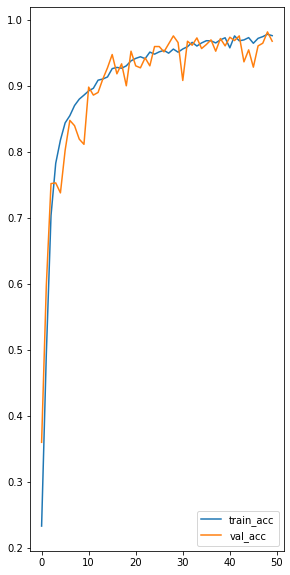

In [18]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), history.history['accuracy'], label='train_acc')
plt.plot(range(EPOCHS), history.history['val_accuracy'], label='val_acc')
plt.legend(loc='lower right')

In [19]:
import numpy as np

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    pred = model.predict(img_array)
    pred_class = class_names[np.argmax(pred[0])]
    
    confidence = round(100 * (np.max(pred[0])), 2)
    return pred_class, confidence

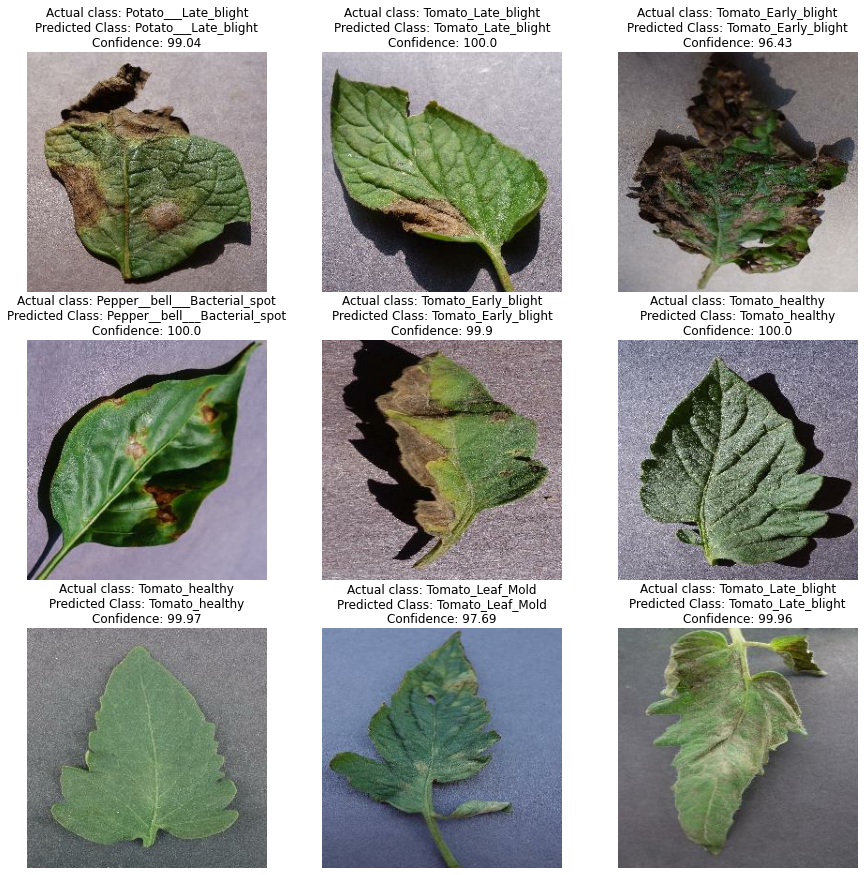

In [20]:
plt.figure(figsize=(15, 15))

for images, labels in test_df.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        pred_class, confidence = predict(model, images[i])
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual class: {actual_class}\nPredicted Class: {pred_class}\nConfidence: {confidence}")
        plt.axis('off')

In [21]:
model.save(f"model/plants_version1")

INFO:tensorflow:Assets written to: model/plants_version1/assets
